CDAE Simulation #3: Binary Fixed Point
=====================

Implementation of CDAE using binary fixed point operations.

In [1]:
%pylab inline --no-import-all

oversampling = 8

fir_h = None
iir_sos = []

with open("cdae_dbg_config.txt", "r") as f:
    for line in f:
        line = line.split()
        if len(line) > 0 and line[0] == "fir_h":
            fir_h = [float(v) for v in line[1:]]
        if len(line) > 0 and line[0] == "iir_sos":
            iir_sos.append([float(v) for v in line[1:]])

fir_h = np.array(fir_h)
iir_sos = np.array(iir_sos)

REF_INPUT_SAMPLES    = np.loadtxt("cdae_dbg_samples.txt")
REF_INPUT_PHASES     = np.loadtxt("cdae_dbg_phases.txt")
REF_INTERP_SAMPLES   = np.loadtxt("cdae_dbg_resampled.txt")
REF_FILTERED_SAMPLES = np.loadtxt("cdae_dbg_filtered.txt")
REF_RESULTS          = np.loadtxt("cdae_dbg_results.txt")

M = REF_INTERP_SAMPLES.shape[0]
N = REF_INTERP_SAMPLES.shape[1]

Populating the interactive namespace from numpy and matplotlib


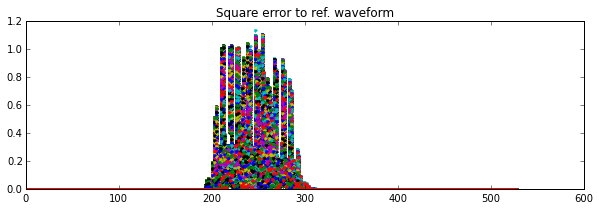

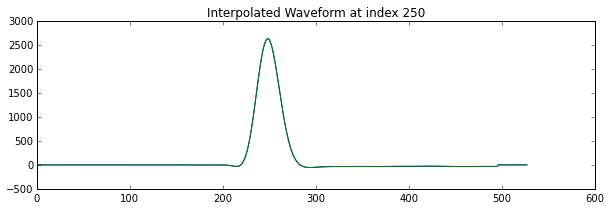

In [2]:
interp_frac_bits = 12

def my_polyphase_fir_filter(isamples):
    int_fir_h = np.array(fir_h * np.exp2(interp_frac_bits), np.int64)
    isamples = np.array((isamples - isamples[0]) * np.exp2(interp_frac_bits), np.int64)
    osamples = np.zeros(len(isamples) * oversampling, np.int64)
    fstate = np.zeros(len(fir_h), np.int64)
    for i in range(len(osamples)):
        fstate = np.roll(fstate, 1)
        fstate[0] = isamples[i//oversampling] if i%oversampling == 0 else 0
        osamples[i] = fstate.dot(int_fir_h) >> interp_frac_bits
    return np.roll(osamples, -len(fir_h)//2)

interp_out = np.zeros((M, N), np.int64)
for i in range(M):
    interp_out[i,:] = my_polyphase_fir_filter(REF_INPUT_SAMPLES[i,:])
    sqerr = (interp_out[i,:] * np.exp2(-interp_frac_bits)) - REF_INTERP_SAMPLES[i,:]
    sqerr = sqerr.dot(sqerr)

plt.figure(figsize=(10, 3))
plt.title("Square error to ref. waveform")
plt.plot(((interp_out*np.exp2(-interp_frac_bits) - REF_INTERP_SAMPLES) ** 2).T, '.')

plt.figure(figsize=(10, 3))
plt.title("Interpolated Waveform at index %d" % (M//2))
plt.plot(interp_out[M//2,:] * np.exp2(-interp_frac_bits))
plt.plot(REF_INTERP_SAMPLES[M//2,:]);

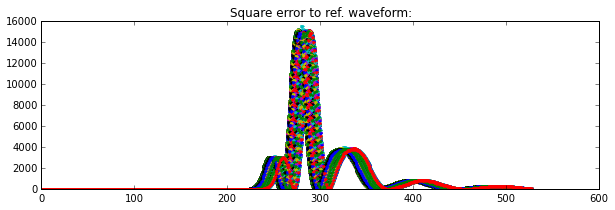

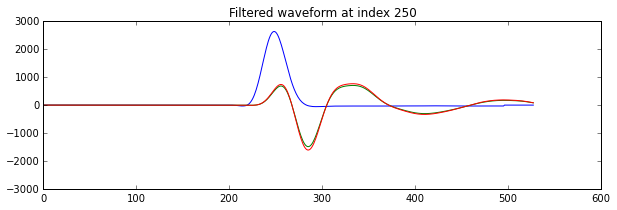

In [3]:
filtered_frac_bits = 16

def my_biquad_iir_filter(sos, samples):
    b0, b1, b2, a0, a1, a2 = [int(v) for v in sos * np.exp2(filtered_frac_bits)]
    assert a0 == 1 << filtered_frac_bits
    
    samples = np.copy(samples, np.int64)
    z1, z2 = [0, 0]
    
    for i in range(len(samples)):
        t = int(samples[i]) - ((a1*z1 + a2*z2) >> filtered_frac_bits)
        samples[i] = (b0*t + b1*z1 + b2*z2) >> filtered_frac_bits
        z1, z2 = t, z1
    
    return samples

filtered_out = np.array(interp_out * np.exp2(filtered_frac_bits - interp_frac_bits), np.int64)
for i in range(M):
    for k in range(iir_sos.shape[0]):
        filtered_out[i,:] = my_biquad_iir_filter(iir_sos[k,:], filtered_out[i,:])

plt.figure(figsize=(10, 3))
plt.title("Square error to ref. waveform:")
plt.plot(((filtered_out*np.exp2(-filtered_frac_bits) - REF_FILTERED_SAMPLES) ** 2).T, ".");

plt.figure(figsize=(10,3))
plt.title("Filtered waveform at index %d" % (M//2))
plt.plot(interp_out[M//2,:]*np.exp2(-interp_frac_bits));
plt.plot(filtered_out[M//2,:]*np.exp2(-filtered_frac_bits));
plt.plot(REF_FILTERED_SAMPLES[M//2,:]);
plt.ylim(-3000, 3000);

standard deviation: 1.10e-04 1.66e-04 5.25e-05 4.43e-05


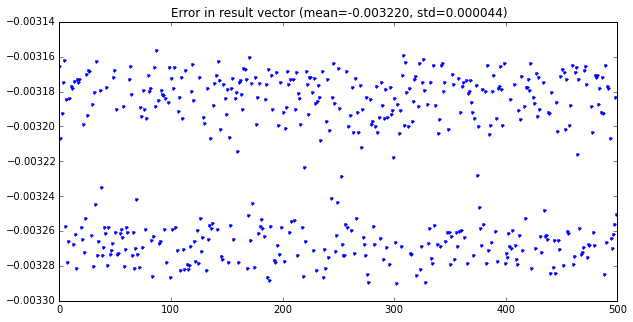

In [4]:
def find_zero_crossings(samples, trig, N):
    zdata = []
    
    for i in range(len(samples)):
        s = samples[i]
        if np.abs(s) > trig:
            break

    for i in range(i, len(samples)-1):
        s1 = samples[i]
        s2 = samples[i+1]
        
        if s2 == 0:
            zdata.append(i)
            zdata.append(s2-s1)
        
        elif (s1 < 0 < s2) or (s1 > 0 > s2):
            zdata.append(i + s1 / (s1 - s2))
            zdata.append(s2-s1)

        if len(zdata) == 2*N:
            break

    assert len(zdata) == 2*N
    return zdata

zd = np.array([find_zero_crossings(filtered_out[i,:]*np.exp2(-filtered_frac_bits), 100, 2) for i in range(M)])

# CDAE statistics data
zavg_diff = np.mean(zd[:, 2] - zd[:, 0])
zavg_del1 = np.mean(zd[:, 1])
zavg_del2 = np.mean(zd[:, 3])

zw = zd[:, 0] * zavg_del1 - zd[:, 2] * zavg_del2
zw = (zw + zavg_diff * 0.5 * (zavg_del1 + zavg_del2)) / (zavg_del1 - zavg_del2)
results = np.vstack([zd[:,0], zd[:,2], (zd[:,0] + zd[:,2]) * 0.5, zw]).T / oversampling
results_err = REF_RESULTS[:,3] - results[:,3]

plt.figure(figsize=(10,5))
plt.title("Error in result vector (mean=%f, std=%f)" % (np.mean(results_err), np.std(results_err)))
plt.plot(results_err, '.')

print("standard deviation: %.2e %.2e %.2e %.2e" % tuple(np.std(REF_RESULTS - results, axis=0)))

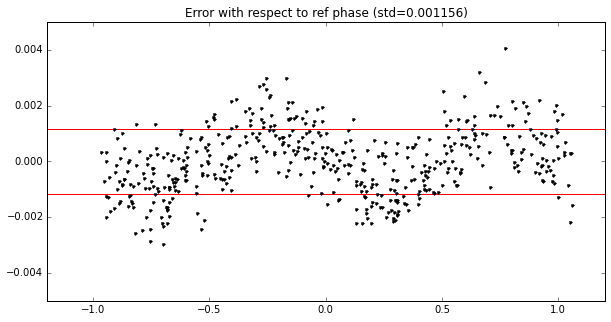

In [5]:
err = results[:,3] - REF_INPUT_PHASES
err -= np.mean(err)
std_err = np.std(err)

plt.figure(figsize=(10,5))
plt.title("Error with respect to ref phase (std=%f)" % std_err)
plt.plot([-1.5, +1.5], [+std_err, +std_err], 'r-')
plt.plot([-1.5, +1.5], [-std_err, -std_err], 'r-')
plt.plot(REF_INPUT_PHASES, err, 'k.')
plt.ylim(-0.005, +0.005)
plt.xlim(-1.2, +1.2);